In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt

## Reading the data files
Here we are only reading the files of the variables we ares interested in.

In [2]:
path = r'/home/daniel/code/costofcare/data/bhp_ukhls_data_stata/UKDA-6614-stata/stata/ukhls'
all_files = glob.glob(os.path.join(path , '*indresp.dta'))
raw_colnames = ['hidp',
                'sex',
                'ethn_dv',
                'dvage',
                'mastat_dv',
                'country',
                'aidhh',
                'aidhrs',
                'aidxhh',
                'fimnlabgrs_dv',
                'fimnlabnet_dv',
                'istrtdatm',
                'istrtdaty']
indresp = []
for filename in all_files:
    prefix = filename.split('/')[-1][0:2]
    colnames = [f'{prefix}{x}' for x in raw_colnames]
    df = pd.read_stata(filename,
                       columns=['pidp'] + colnames)
    indresp.append(df)

In [3]:
df = indresp[0]

In [24]:
cpih = pd.read_csv('./cpih_uk_88_23.csv')
cpih['date'] = pd.to_datetime(cpih.date, format='%b-%y')
cpih.dtypes

date    datetime64[ns]
cpih           float64
dtype: object

In [50]:

df.a_istrtdaty.value_counts()

#df['date'] = df.a_istrtdaty.astype(str)+'/'+df.a_istrtdatm.astype(str)
#df['date'] = pd.to_datetime(df.date, format='%Y/%B')

2009            24381
2010            23818
2011             1775
inapplicable      990
missing            30
Name: a_istrtdaty, dtype: int64

In [48]:
df

,pidp,a_hidp,a_sex,a_ethn_dv,a_dvage,a_mastat_dv,a_country,a_aidhh,a_aidhrs,a_aidxhh,a_fimnlabgrs_dv,a_fimnlabnet_dv,a_istrtdatm,a_istrtdaty,date
0,68001367,68001363,male,british/english/scottish/welsh/northern irish,39,Single and never married/in civil partnership,England,inapplicable,inapplicable,no,1900.000000,1400.000000,January,2009,2009/January
1,68004087,68004083,male,any other white background,59,Divorced,England,inapplicable,inapplicable,no,1075.000000,800.000000,January,2009,2009/January
2,68006127,68006123,female,british/english/scottish/welsh/northern irish,39,Living as couple,England,no,inapplicable,no,0.000000,0.000000,January,2009,2009/January
3,68006135,68006123,female,british/english/scottish/welsh/northern irish,17,Single and never married/in civil partnership,England,no,inapplicable,no,0.000000,0.000000,January,2009,2009/January
4,68006807,68006803,female,british/english/scottish/welsh/northern irish,72,Divorced,England,inapplicable,inapplicable,no,0.000000,0.000000,January,2009,2009/January
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50989,1634643847,1634643843,female,bangladeshi,38,Married,England,no,inapplicable,no,0.000000,0.000000,February,2011,2011/February
50990,1634644527,1634644523,male,bangladeshi,33,Married,England,no,inapplicable,no,427.109985,416.709991,February,2011,2011/February
50991,1634644531,1634644523,female,bangladeshi,30,Married,England,no,inapplicable,no,0.000000,0.000000,February,2011,2011/February
50992,1634649967,1634649963,male,pakistani,22,Married,England,no,inapplicable,no,450.000000,450.000000,February,2011,2011/February


## Concatenating the files by pidp
`pidp` is the unique identifiers of the person in each data file. Here, we are performing "first wave is key" merge.

In [87]:
indresp_df = indresp[0]['pidp']
for df in indresp:
    indresp_df = pd.merge(indresp_df, df, on='pidp', how='left')

### General overview of `aidhh`: 'cares for sick/disabled/elderly in household'; `aidxhh`: non-residents cared for, across the 12 waves.

Below we are doing some house keeping first, homologating all value labels across waves

In [88]:
indresp_df = indresp_df.replace({'Yes': 'yes', 'No': 'no', 'no     ': 'no', 'yes    ': 'yes'})

Now we procede to plot the evolution on valid cases per wave:

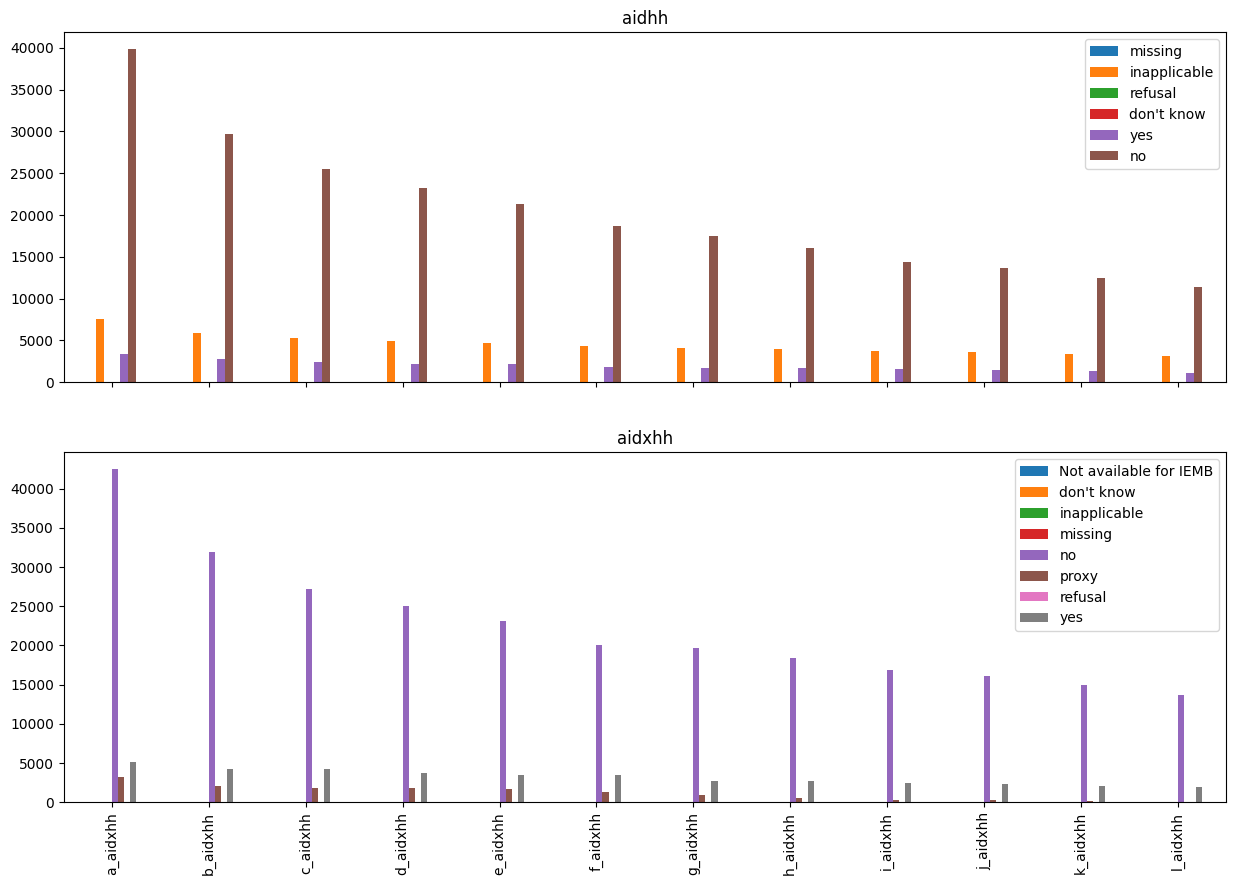

In [89]:
aidhh = []
aidxhh = []
for colname in indresp_df.columns:
    if 'aidhh' in colname:
        aidhh.append(colname)
    if 'aidxhh' in colname:
        aidxhh.append(colname)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
indresp_df[aidhh].apply(pd.Series.value_counts).T.plot.bar(ax=ax1)
indresp_df[aidxhh].apply(pd.Series.value_counts).T.plot.bar(ax=ax2)
ax1.set_title('aidhh')
ax2.set_title('aidxhh')
plt.show()

As it can be seen above, the valid sample of the cohort of the first wave goes from around 50k to 15k. Still a considerable sample size. Another interesting note is that carers raw number seems to be dropping lerss than non-carers raw number. And important note, the missing label correspond to 'missing at the time of the interview' and not a dropped case.

## Wage variables overview

Wage columns in the original dataset are store as a category in order to include other responses types in the question (e.g. refusal, don't know, etc). This must be recoded.

In [146]:
for colname in indresp_df.columns:
    if 'fimnlabnet_dv' in colname:
        indresp_df[colname] = pd.to_numeric(indresp_df[colname], errors='coerce')
        indresp_df[colname] = indresp_df[colname].where(indresp_df[colname] >= 0)
    if 'fimnlabgrs_dv' in colname:
        indresp_df[colname] = pd.to_numeric(indresp_df[colname], errors='coerce')
        indresp_df[colname] = indresp_df[colname].where(indresp_df[colname] >= 0)

The above code first convert the columns to numeric and then recode all negative values to NaN so it can ignored. 

The code below, on the other hand selects the net and and the gross columns and computes the average wage per wave, excluding the people reporting 0 wage.

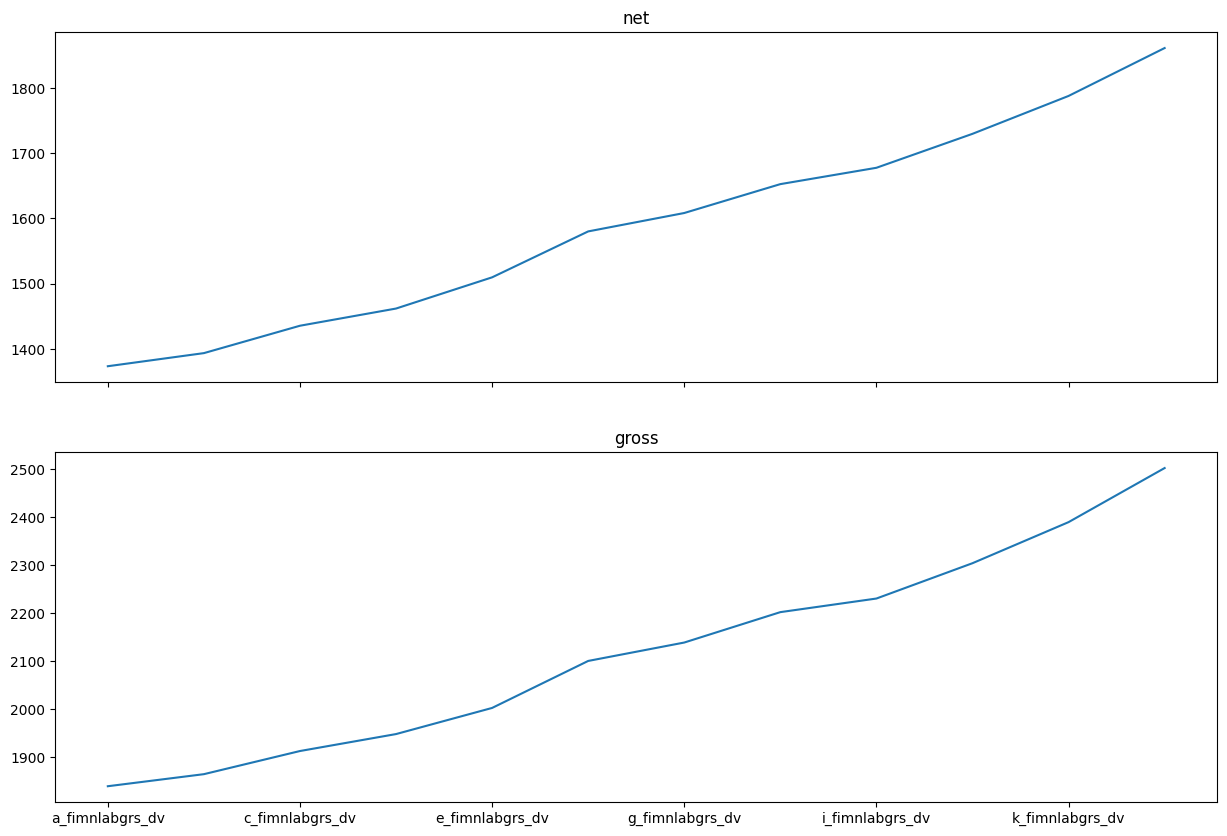

In [148]:
net = []
gross = []
for colname in indresp_df.columns:
    if 'fimnlabnet_dv' in colname:
        net.append(colname)
    if 'fimnlabgrs_dv' in colname:
        gross.append(colname)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
indresp_df[net].where(indresp_df[net] > 0).apply(pd.Series.mean).T.plot(ax=ax1)
indresp_df[gross].where(indresp_df[gross] > 0).apply(pd.Series.mean).T.plot(ax=ax2)
ax1.set_title('net')
ax2.set_title('gross')
plt.show()

As it can be seen above net wages go from a little below 1400 pounds in the first wave, to just below 1900 in the last wave, where the gross wages go from below 1900 to around 2500 pounds.